# Pair Trading USD.AUD v. USD.CAD Using the Johansen Eigenvector

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen

## Load Data

In [2]:
USDCADdf = pd.read_csv('data/USDCAD_history.csv', skiprows=1)
USDCADdf.columns = ['Date', 'Close', 'Volume', 'Open', 'High', 'Low']
USDCADdf['Date'] = pd.to_datetime(USDCADdf['Date'], errors='coerce')
USDCADdf['Close'] = pd.to_numeric(USDCADdf['Close'], errors='coerce')

AUDUSDdf = pd.read_csv('data/AUDUSD_history.csv', skiprows=1)
AUDUSDdf.columns = ['Date', 'Close', 'Volume', 'Open', 'High', 'Low']
AUDUSDdf['Date'] = pd.to_datetime(AUDUSDdf['Date'], errors='coerce')
AUDUSDdf['Close'] = pd.to_numeric(AUDUSDdf['Close'], errors='coerce')

## Logic and Strategy

In [3]:
cad = 1.0 / USDCADdf['Close']
aud = AUDUSDdf['Close']
y = pd.concat([aud, cad], axis=1, keys=['AUDUSD', 'CADUSD'])
y.dropna(inplace=True)

trainlen = 250
lookback = 20

hedgeRatio = pd.DataFrame(index=y.index, columns=y.columns)
numUnits = pd.Series(index=y.index)

for t in range(trainlen, len(y)):
    y_windowed = y.iloc[t-trainlen:t]
    res = coint_johansen(y_windowed, 0, 1)
    
    hedgeRatio_current = pd.Series(res.evec[:, 0], index=y.columns)
    yport = (y.iloc[t-lookback+1:t] * hedgeRatio_current).sum(axis=1)
    ma = yport.mean()
    mstd = yport.std()
    zScore = (yport.iloc[-1] - ma) / mstd
    
    hedgeRatio.iloc[t] = hedgeRatio_current
    numUnits.iloc[t] = -(yport.iloc[-1] - ma) / mstd

positions = numUnits.shift() * hedgeRatio.shift() * y
positions.dropna(inplace=True)
pnl = (positions.shift(1) * (y - y.shift(1)) / y.shift(1)).sum(axis=1)
ret = pnl / (positions.shift(1).abs().sum(axis=1) + 1e-10)

## Visualization & Returns

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1352    NaN
1353    NaN
1354    NaN
1355    NaN
1356    NaN
Length: 1357, dtype: object


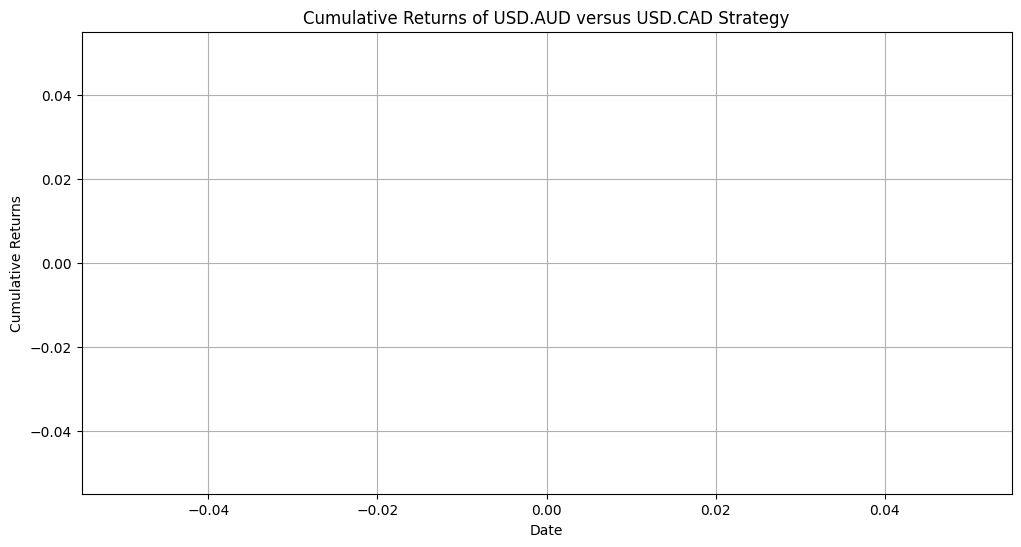

APR: nan%
Sharpe Ratio: nan


In [4]:
cumulative_returns = (1 + ret).cumprod() - 1

print(cumulative_returns)

plt.figure(figsize=(12,6))
cumulative_returns.plot()
plt.title('Cumulative Returns of USD.AUD versus USD.CAD Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

# APR and Sharpe Ratio
daily_rf = 0.053  # 5-month T-bond rate
excess_daily_return = ret - daily_rf
sharpe_ratio = excess_daily_return.mean() / excess_daily_return.std()
annualized_return = ((1 + ret).cumprod().iloc[-1]) ** (252 / len(ret)) - 1

print(f"APR: {annualized_return * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")